In [18]:
import time
from configparser import ConfigParser
from Common.helper import format_two_point_time
from specdal import Collection, Spectrum, read
from matplotlib import pyplot as plt
import numpy as np
import csv
import os
import re
import argparse
import pandas as pd

# print('pandas = ' + pd.__version__)


In [19]:
start = time.time()
print("start processing asd files")



start processing asd files


In [24]:
 parser = argparse.ArgumentParser(description='Argument indicating the configuration file')
 # add configuration argument
 parser.add_argument("-c", "--config", help="add a configuration file you would like to process the asd data"
                                               " \n ex. py run_asd_processing.py -c config_template.conf",
                        action="store", default='config_template.conf')
# parse config to args.config
args = parser.parse_args("")
config_file = args.config
print('config file: ' + config_file)

config file: config_template.conf


In [26]:
#Read config.conf file
config_object = ConfigParser()
config_object.read(config_file)

#Get the input
asd_path = config_object["INPUT"]["asd_path"]
sample_mapping_file = config_object["INPUT"]["sample_mapping_file"]
no_of_asd_per_sample = int(config_object["INPUT"]["no_of_asd_per_sample"])

print("asd_path is {}".format(asd_path))
print("sample_mapping_file is {}".format(sample_mapping_file))
print("no_of_asd_per_sample is {}".format(no_of_asd_per_sample))




asd_path is D:\git\spectrometer-process-tool\input\asd
sample_mapping_file is D:\git\spectrometer-process-tool\input\sample_mapping_template.csv
no_of_asd_per_sample is 24


HEADER: PLOT, SAMPLE_ID, LEAF, HEALTH, ASD1, ASD2, ASD3, ASD4, ASD5, ASD6, ASD7, ASD8, ASD9, ASD10, ASD11, ASD12, ASD13, ASD14, ASD15, ASD16, ASD17, ASD18, ASD19, ASD20, ASD21, ASD22, ASD23, ASD24
Plot-Sample: CR11-10-L17-K_Mg
export_to_csv: D:\git\spectrometer-process-tool\output\csv\CR11-10-L17-K_Mg.csv
Plot-Sample: CR11-11-L17-K_Mg
export_to_csv: D:\git\spectrometer-process-tool\output\csv\CR11-11-L17-K_Mg.csv
Plot-Sample: CR11-12-L33-K_Mg
export_to_csv: D:\git\spectrometer-process-tool\output\csv\CR11-12-L33-K_Mg.csv
Plot-Sample: SR08-13-L33-K_Mg
export_to_csv: D:\git\spectrometer-process-tool\output\csv\SR08-13-L33-K_Mg.csv
Processed 5 lines.


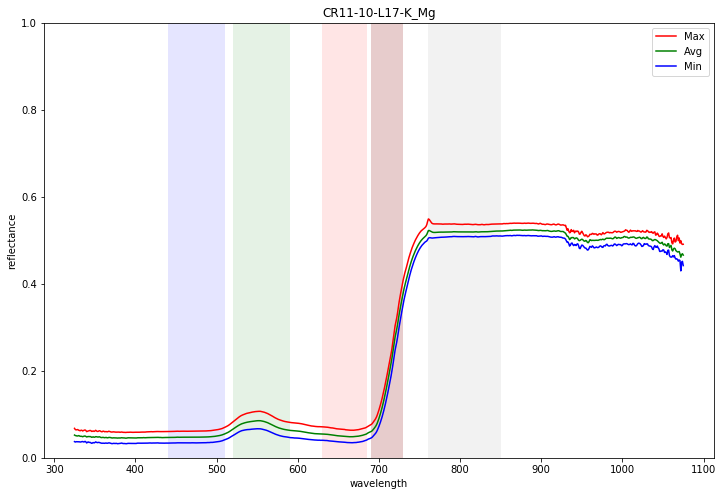

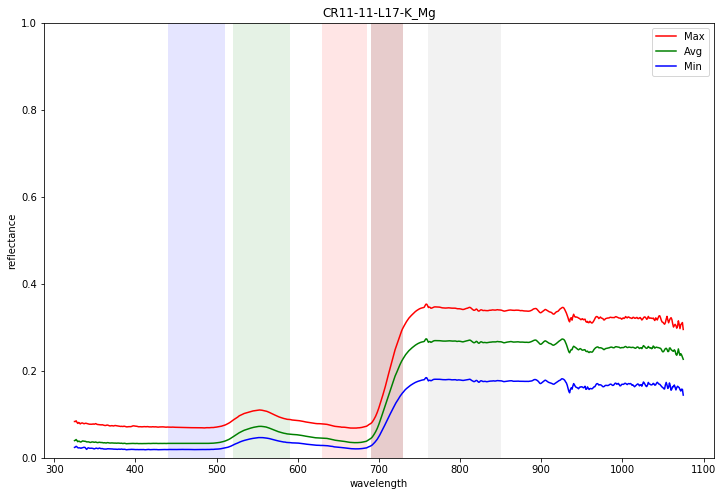

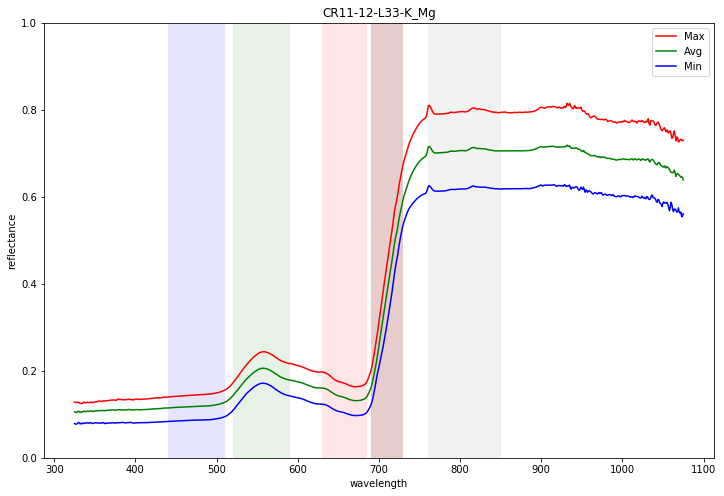

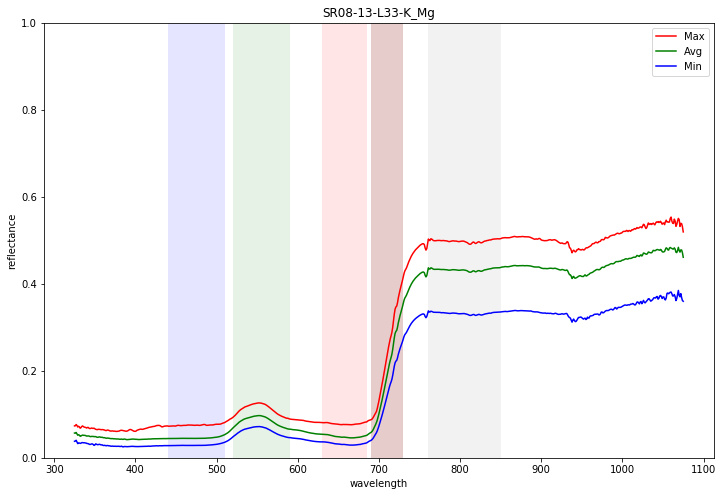

In [27]:
# read sample_mapping_file
graph_min = float(config_object["PROCESSING"]["graph_min"])
graph_max = float(config_object["PROCESSING"]["graph_max"])
output_csv = bool(config_object["OUTPUT"]["output_csv"] == "true")
output_graph = bool(config_object["OUTPUT"]["output_graph"] == "true")

output_path = config_object["OUTPUT"]["output_path"]
output_path_csv =os.path.join(output_path, 'csv')
output_path_graph =os.path.join(output_path, 'graph')

if not os.path.exists(output_path_csv):
    os.makedirs(output_path_csv)
if not os.path.exists(output_path_graph):
    os.makedirs(output_path_graph)

with open(sample_mapping_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'HEADER: {", ".join(row)}')
            line_count += 1
        else:
            plot_sample_name = re.sub('[\\\\/:*?"<>|,]', '_', (row[0]+"-"+row[1]+"-L"+row[2]+"-"+row[3]))
            print(f'Plot-Sample: {plot_sample_name}')

            c = Collection(name=plot_sample_name)
            for x in range(4, no_of_asd_per_sample+4):
                asd_file = row[x] + ".asd"
                # print('\t'+asd_file)
                spectrum = Spectrum(filepath=os.path.join(asd_path, asd_file))
                c.append(spectrum)

            # print(type(c.data))
            c.data.head()
            if (output_graph): 
                c.plot(title=plot_sample_name,legend=False, ylim=(graph_min, graph_max),ylabel='reflectance',figsize=(12,8))
                # plt.show()
                plt.axvspan(440, 510, facecolor='b', alpha=0.1)
                plt.axvspan(520, 590, facecolor='g', alpha=0.1)
                plt.axvspan(630, 685, facecolor='r', alpha=0.1)
                plt.axvspan(690, 730, facecolor='darkred', alpha=0.2)
                plt.axvspan(760, 850, facecolor='gray', alpha=0.1)
                plt.savefig(os.path.join(output_path_graph, plot_sample_name)+"_all.jpg")
                plt.clf()
                data_max = c.max()
                data_mean = c.mean()
                data_min = c.min()
                data_max.plot(title=plot_sample_name,legend=True, ylim=(graph_min, graph_max),ylabel='reflectance',color='r',label='Max',figsize=(12,8))
                data_mean.plot(title=plot_sample_name,legend=True, ylim=(graph_min, graph_max),ylabel='reflectance',color='g',label='Avg',figsize=(12,8))
                data_min.plot(title=plot_sample_name,legend=True, ylim=(graph_min, graph_max),ylabel='reflectance',color='b',label='Min',figsize=(12,8))
                plt.axvspan(440, 510, facecolor='b', alpha=0.1)
                plt.axvspan(520, 590, facecolor='g', alpha=0.1)
                plt.axvspan(630, 685, facecolor='r', alpha=0.1)
                plt.axvspan(690, 730, facecolor='darkred', alpha=0.2)
                plt.axvspan(760, 850, facecolor='gray', alpha=0.1)
                plt.savefig(os.path.join(output_path_graph, plot_sample_name)+"_min_max_avg.jpg")


            if (output_csv): 
                output_file_name = os.path.join(output_path_csv, plot_sample_name)+".csv"
                print('export_to_csv: {}'.format(output_file_name))
                if os.path.exists(output_file_name):
                    os.remove(output_file_name)
                
                data_t = c.data.transpose()
                data_t.insert(0, 'SAMPLE_CODE', plot_sample_name)
                data_t.index.name = 'ASD_FILE'
                data_t.to_csv(output_file_name, sep=',', encoding='utf-8')

            line_count += 1

    print(f'Processed {line_count} lines.')




In [28]:
print('Overall time elapsed: {} seconds'.format(format_two_point_time(start, time.time())))

Overall time elapsed: 124.23 seconds
